# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

###MNIST 데이터셋

미국 고등학생과 인구조사국 직원들이 손으로 쓴 7만개의 숫자 이미지로 구성된 데이터셋


*   사용된 0부터 9까지의 숫자는 각각 28 * 28 = 784 크기의 픽셀로 구성된 이미지 데이터


  *   2차원 array가 아닌 길이가 784인 1차원 array로 제공


*   레이블 : 총 7만 개의 샘플이 표현하는 값

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

data 키: 샘플이 하나의 행, 특성이 하나의 열로 구성된 data 배열


target: 레이블 배열

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

70000개의 이미지, 각 이미지는 784개의 특성(28x28)


개개의 특성은 0~255까지의 픽셀 강도

그림 저장: some_digit_plot


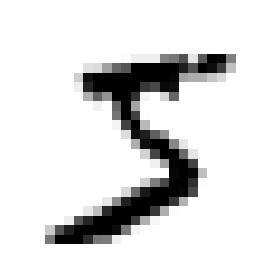

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
#실제 레이블 확인 - 일치
y[0]  

'5'

In [9]:
#레이블을 정수로 변환
y = y.astype(np.uint8)  

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


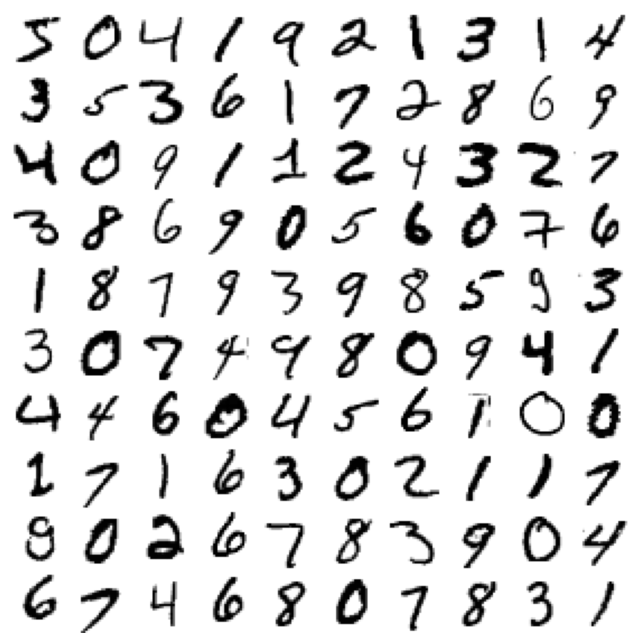

In [12]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [17]:
y[0]

5

In [18]:
#테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

*   '5'만 식별하도록 훈련
*   '5'와 '5 아님' 두 개의 클래스를 구분하는 이진 분류기

In [19]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)



##  확률적 경사 하강법(Stochastic Gradient Descent, SGD) 분류기
  *   매우 큰 데이터셋을 효율적으로 처리하는 장점 (한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)
  *   온라인 학습에 잘 맞음



In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# 성능 측정

## 교차 검증을 사용한 정확도 측정
- StratifiedKFold를 이용한 교차 검증 구현
  - stratified 는 label의 분포를 유지시켜줌
  - 각 fold 안의 데이터셋의 label 분호가 전체 데이터 셋의 label 분포를 따르기 때문에,
각 fold가 전체 데이터셋을 잘 대표한다.


  즉, 모델을 학습시킬 때 편항되지 않게 학습시킬 수 있다. 

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  #분류기 객체 (모델)을 복제 후 훈련
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [23]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

##모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기

###정확도가 90%이상 (무조건 '5 아님'으로 예측해도 90% 정확도)

####=> 이미지의 10%만 숫자 5 인 불균형한 데이터셋

####=> 정확도를 분류기의 성능 측정 지표로 선호하지 않음

## 오차 행렬

- 분류기의 성능을 평가하는 좋은 방법
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 = 오차 행렬의 5행 3열

In [25]:
from sklearn.model_selection import cross_val_predict

#cross_val_predict() k-겹 교차 겸증 수행, 각 테스트 폴드에서 얻은 예측 반환
#평가 점수 반환X
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
#오차행렬
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 첫번째 행 : '5 아님' 이미지에 대한 것(음성 클래스) 53892개를 '5 아님'으로 정확히 분류(진짜 음성), 687개는 '5'라고 잘못 분류(거짓 양성)
- 두번째 행 : '5' 이미지에 대한 것(양성 클래스) 1891개를 '5 아님'으로 잘못 분류(거짓 음성), 3530개는 '5'라고 정확히 분류(진짜 양성)
- 완벽한 분류기라면 오차 행렬의 주대각선만 0이 아닌 값이 됨

In [28]:
# 완변한 분류기
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

##정밀도 (precision)
- 양성 예측의 정확도
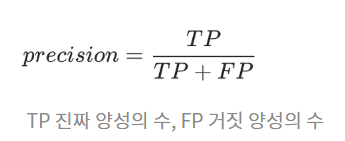
- '5'라고 분류된 것들 중, 실제 '5'인 비율
- '정밀도'는 '재현율'과 같이 사용하는 것이 일반적

##재현율
- 민감도, 진짜 양성 비율
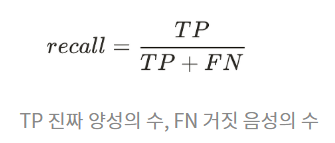
- 실제 '5' 이미지에 대해, '5' 라고 정확히 분류된 것의 비율
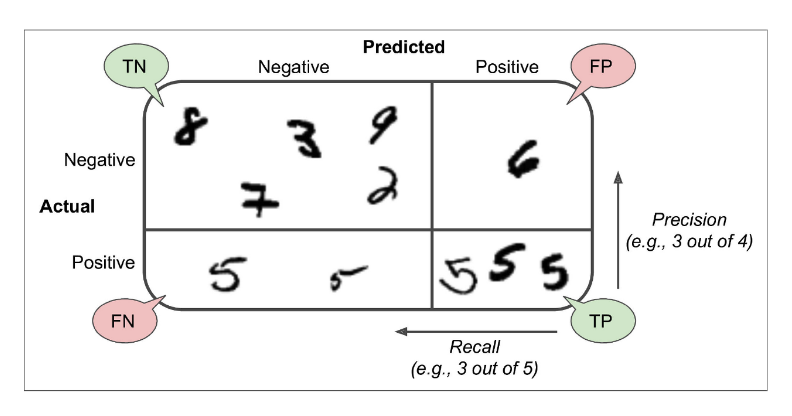


In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

ㄴ> 5로 판별된 이미지 중 83.7%만 정확


In [30]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

ㄴ> 전체 5에 대해 65.1%만 정확히 5로 감지

In [31]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

###F1 score (정밀도와 재현율의 조화평균)
- 정밀도와 재현율이 비슷한 분류기에서 F1 점수가 높음

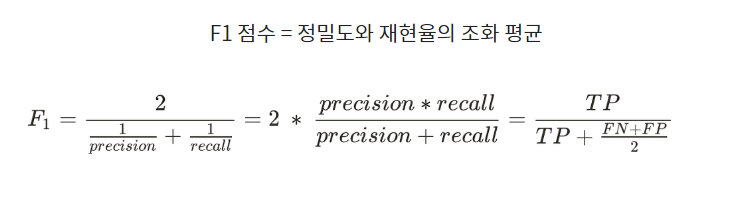



In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [34]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## 정밀도/재현율 트레이드오프
- 정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어드는 정밀도/재현율 트레이드오프 존재

##SGDClassifier 분류기는 결정함수를 사용하여 샘플 점수 계산
- 샘플점수 > 임계값 => 샘플을 양성 클래스에 할당
- 샘플점수 < 임계값 => 샘플을 음성 클래스에 할당

사이킷런에서 임계값을 지정할 수는 없지만, 예측에 사용한 점수는 확인가능

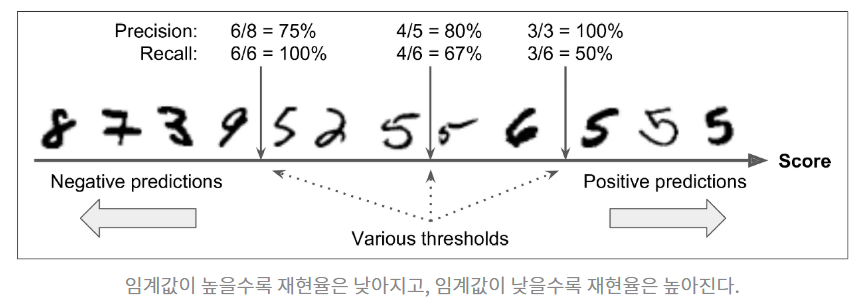

- 결정 임계값이 가운데 화살표일 경우,
  - 임계값 오른쪽에 4개의 진짜 양성(실제 5)과 하나의 거짓양성(6)이 있으므로 이 임계값에서 정밀도는 80%(4/5)

  - 실제 숫자 5는 총 6개고 분류기는 4개를 5라고 감지했으므로 재현율은 67%(4/6)

- 임계값을 높이면 거짓양성이 진짜 음성이 되어 정밀도가 높아지고,진짜 양성 하나가 거짓음성이 되었으므로 재현율이 50%로 줄어듦
- 반대로 임계값을 내리면 재현율은 높아지고, 정밀도는 줄어듦

In [35]:
##predict() 대신 decision_function()을 통해 각 샘플의 점수 확인 가능
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [36]:
#샘플 점수를 기반으로 임계값을 정해 예측 생성
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [37]:
y_some_digit_pred

array([ True])

In [38]:
# 임계값을 높이면 재현율이 줄어듦
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

##적절한 임계값을 정하기

- cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구함
- 예측결과가 아닌 결정 점수를 반환받도록 지정
- precision_recall_curve() 사용해 가능한 모든 임계값에 대해 정밀도와 재현율 계산

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


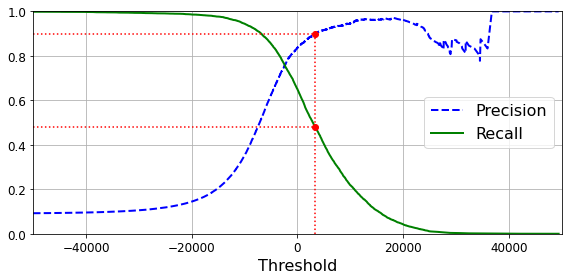

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [43]:
(y_train_pred == (y_scores > 0)).all()

True

그림 저장: precision_vs_recall_plot


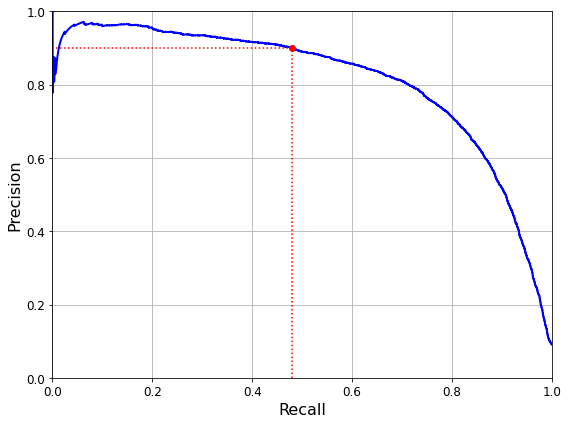

In [44]:
#재현율에 대한 정밀도 곡선
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하게 줄어듦
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택

In [45]:
# 정밀도 90% 달성이 목표라면 최소 90% 정밀도가 되는 가장 낮은 임계값을 찾음
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
threshold_90_precision

3370.0194991439557

In [47]:
# predict()대신 해당 임계값을 사용
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선

##Receiver operating characteristic, 수신기 조작 특성 곡선
- 정밀도에 대한 재현율 곡선이 아닌,
거짓 양성 비율(FPR) 에 대한 진짜 양성 비율(TPR, 재현율) 곡선
- FPR은 양성으로 잘못 분류된 음성 샘플의 비율
- FPR = 1 - TNR(진짜 음성 비율, 음성으로 잘 분류된 음성 샘플 비율, 특이도)

=> ROC 곡선은 민감도(재현율)에 대한 (1-특이도) 그래프

In [51]:
#먼저 roc_curve()로 여러 임계값에서 TPR과 FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


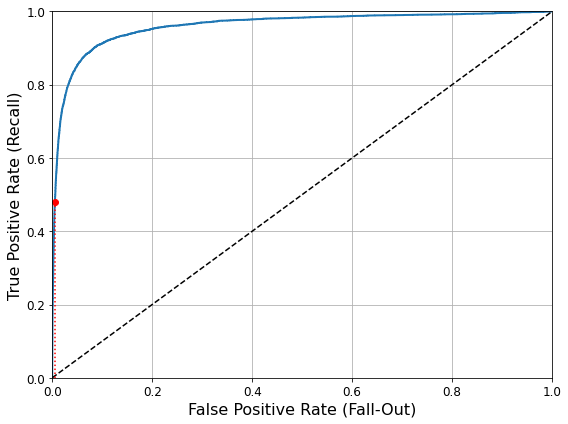

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

##Trade-off
- 재현율이 높을 수록 분류기가 만드는 거짓 양성이 늘어남
- 점선은 랜덤 분류기의 ROC 곡선으로, 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야함
- 곡선 아래의 면적(area under the curve, AUC)을 측정하면 분류기 비교 가능
  - 완벽한 분류기는 ROC의 AUC가 1, 완전한 랜덤 분류기는 0.5

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 정밀도/재현율 곡선
- 반대의 경우 ROC 곡선 (음성에 비해 양성이 크게 적어 ROC의 AUC 점수가 좋게 나옴)

##RandomForestClassifier 와 SGDClassifier 의 비교

- deicision_function() 대신 predict_proba()
- predict_proba() : 샘플이 행, 클래스가 열이며 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [55]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [57]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스의 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


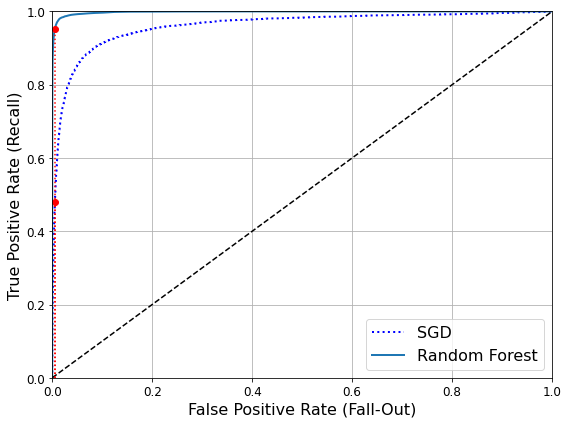

In [58]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

ㄴ> ROC의 AUC 값이 더 큰 랜덤 포레스트 분류기가 더 좋다고 할 수 있음

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [61]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [62]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 다중 분류

- 이진 분류는 두 개의 클래스 구별
- 다중 분류기(다항 분류기)는 둘 이상의 클래스 구별
- 이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법 OvR, OvA, OvO
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 OvR 또는 OvO 실행

In [63]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
#샘플당 10개의 점수 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [66]:
#가정 높은 점수가 클래스 5에 해당하는 값
np.argmax(some_digit_scores)

5

In [67]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [68]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO이나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier을 사용
- 이진 분류기 인스턴스를 만들어 객체 생성시 전달

In [70]:
# SVC 기반으로 OvR을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [71]:
len(ovr_clf.estimators_)

10

- SGD분류기는 직접 다중 클래스 분류가 가능
- decision_function() 메서드는 클래스마다 하나의 값 반환

In [72]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [73]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [75]:
#입력 스케일을 조정해서 정활도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

- 가능성이 높은 모델을 찾았다고 가정하고 모델의 성능을 향상시키기 위해 만들어진 에러의 종류를 분석

In [76]:
#오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [77]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

그림 저장: confusion_matrix_plot


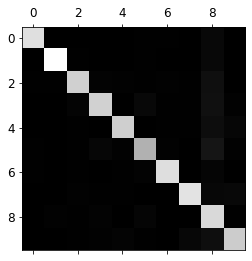

In [78]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 대부분의 이미지기 올바르게 분류되었음 (주대각선에 위치)
- 숫자 5가 다른 숫자보다 어두움 -> 5의 이미지가 적거나 분류기가 5을 잘 분류 못함

In [79]:
# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


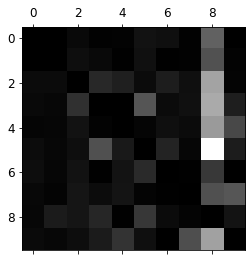

In [80]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- 행은 실제 클래스, 열은 예측한 클래스
- 클래스 8의 열이 밝음 => 많은 이미지가 8로 잘못 분류되었음
- 클래스 8의 행은 나쁘지 않음 = 실제 8은 적절히 8로 분류되었음
- 3과 5 또한 서로 혼동되고 있음
- 8로 잘못 분류되는 것을 줄이도록 개선
  - 8처럼 보이지만 8이 아닌 숫자 데이터를 많이 모아 학습
  - 동심원 수를 세는 알고리즘 같은 새 특성을 찾아 추가

그림 저장: error_analysis_digits_plot


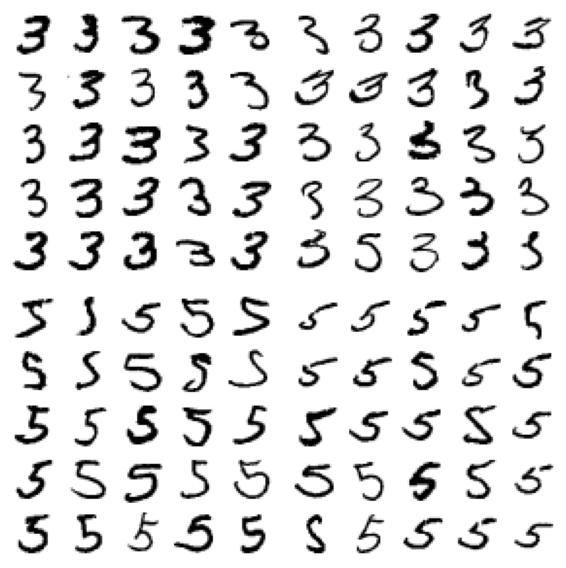

In [81]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

- 왼쪽 블록 두개는 3으로 분류된 이미지
- 오른쪽 블록 두개는 5로 분류된 이미지
- 선형 분류기 SGDClassifier
  - 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산
  - 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동

# 다중 레이블 분류

- 이진 분류는 두 개의 클래스 구별
- 다중 분류기(다항 분류기)는 둘 이상의 클래스 구별

 

###이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법

1. e.g., 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)를 훈련시켜 클래스 10개인 숫자 이미지 분류 시스템을 만드는 방법 (이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택)
=> OvR(one-versus-the-rest) 전략, 또는 OvA(one-versus-all)

 
2. e.g., 0과 1 구별, 0과 2 구별 등과 같이 숫자 조합마다 이진 분류기를 훈련시키는 것.
=>OvO(one-versus-one)
  - 클래스가 N개라면 분류기는 N*(N-1)/2 개가 필요함. (MNIST 는 45개의 분류기를 훈련)
  - 이미지 하나를 분류하려면 45개 분류기를 모두 통과시켜 가장 많이 양성으로 분류된 클래스 선택
  - 각 분류기 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이 장점


- 대부분의 이진 분류 알고리즘은 OvR을 선호

- 서포트 벡터 머신같은 훈련 세트의 크기에 민감한 알고리즘은 OvO 선호

- 분류기가 샘플마다 여러개의 클래스를 출력해야하는 경우
  - 한 사진에 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련하면 분류기가 [1,0,1]을 출력해야함
  - 여러 개의 이진 꼬리표를 출력하는 분류 시스템


- 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦
  - 첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고
  - 두 번째는 홀수인지 나타냄
  - 다중 타깃 배열을 사용하여 훈련

In [82]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [83]:
knn_clf.predict([some_digit])

array([[False,  True]])

숫자 5는 크지않고(False), 홀수(True)

In [84]:
#다중 레이블 분류기 평가
#모든 레이블에 대한 F1 점수의 평균
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화
###이미지 잡음 제거 시스템

- 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
- 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개(0~255 픽셀 강도) 가짐

In [85]:
#이미지 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


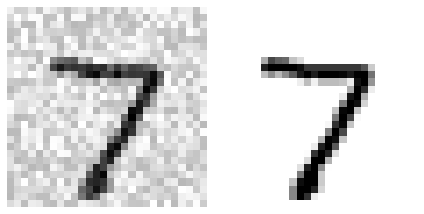

In [86]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

그림 저장: cleaned_digit_example_plot


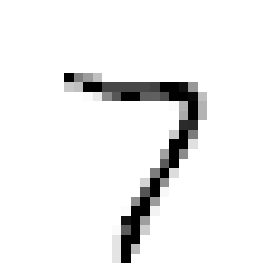

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")